## **Introduction-**
A home is often the largest and most expensive purchase a person makes in his or her lifetime.The price of a house can be determined by its features and the locality in which it is located and thats what the Zillow company does,it determines the estimated price of a house based on its features and locality.In this project we are provided with the dataset by the Zillow company which contains the characteristics of multiple houses along with the infomation of their location and we are going to use machine learning to make the most out of the data and make the estimates made by the Zillow group more accurate.

## **Goal-**
This is a Machine learning project used for predicting the log-error between the estimated value and actual sale price of a house using all the features of a home which are used to find the estimate value of the house. The use of this project is to find the range of the price of a house which can be considered by taking the estimation of the price and the log-error into consideration.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/train-2017/train_2017.csv
/kaggle/input/train-2016-v2/train_2016_v2.csv
/kaggle/input/properties-2017/properties_2017.csv
/kaggle/input/properties-2016/properties_2016.csv


In [3]:
from enum import Enum
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb
from datetime import datetime
import gc
from sklearn.model_selection import train_test_split

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

train06_path      = '../input/train-2016-v2/train_2016_v2.csv'
train07_path      = '../input/train-2017/train_2017.csv'
properties06_path = '../input/properties-2016/properties_2016.csv'
properties07_path = '../input/properties-2017/properties_2017.csv'


## **1.Loading the dataset**

In [5]:

train06_df = pd.read_csv(train06_path, parse_dates=["transactiondate"])
train07_df = pd.read_csv(train07_path, parse_dates=["transactiondate"])
        
prop06_df = pd.read_csv(properties06_path, low_memory = False)
prop07_df = pd.read_csv(properties07_path, low_memory = False)


Combining the train06_df and train07_df datasets for complete data visualization,preprocessing and modeling

In [6]:
train_df=pd.concat([train06_df, train07_df], axis=0)

In [7]:
train06_df.shape

(90275, 3)

In [ ]:
train07_df.shape

## **2.Data visualization and preprocessing**

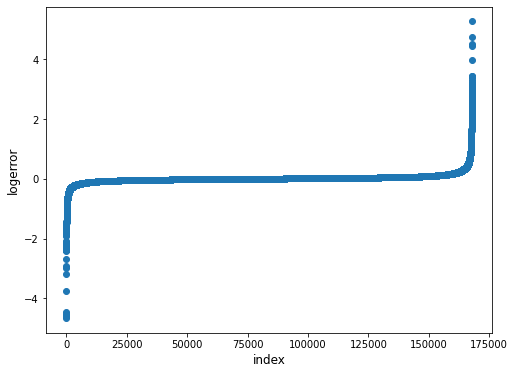

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.logerror.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('logerror', fontsize=12)
plt.show()

This looks nice with some outliers at both the ends.!

Let us create a histogram plot on the same.

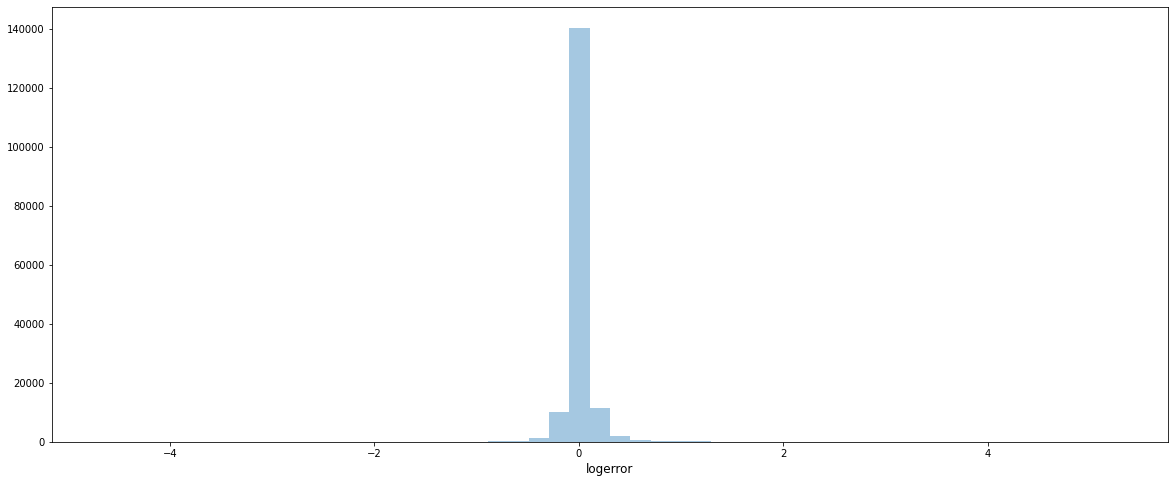

In [9]:

plt.figure(figsize=(20,8))
sns.distplot(train_df.logerror.values, bins=50, kde=False)
plt.xlabel('logerror', fontsize=12)
plt.show()

Thats a normal distribution on the log error.

Now let us explore the date field. Let us first check the number of transactions in each month.

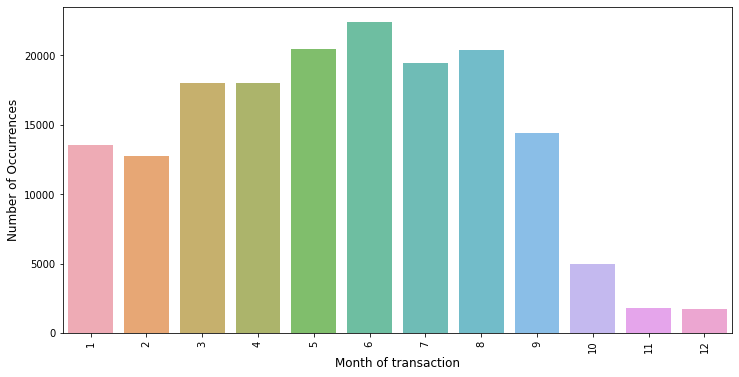

In [10]:
train_df['transaction_month'] = train_df['transactiondate'].dt.month

cnt_srs = train_df['transaction_month'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.xticks(rotation='vertical')
plt.xlabel('Month of transaction', fontsize=12)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.show()

As we could see from the data page as well The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016.

So we have shorter bars in the last three months.

**Parcel ID:**

In [11]:
(train_df['parcelid'].value_counts().reset_index())['parcelid'].value_counts()

1    162541
2      2660
3         9
Name: parcelid, dtype: int64

Here we observe that most of the parcel ids are appearing only once in the dataset.

**Properties**

In [12]:
prop_df = pd.concat([prop06_df, prop07_df], axis=0)

Deleting the unwanted dataframes

In [ ]:
del train06_df
del prop06_df
del train07_df
del prop07_df  

Now let us explore the properties file.

In [13]:
prop_df.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


There are so many NaN values in the dataset. So let us first do some exploration on that one.

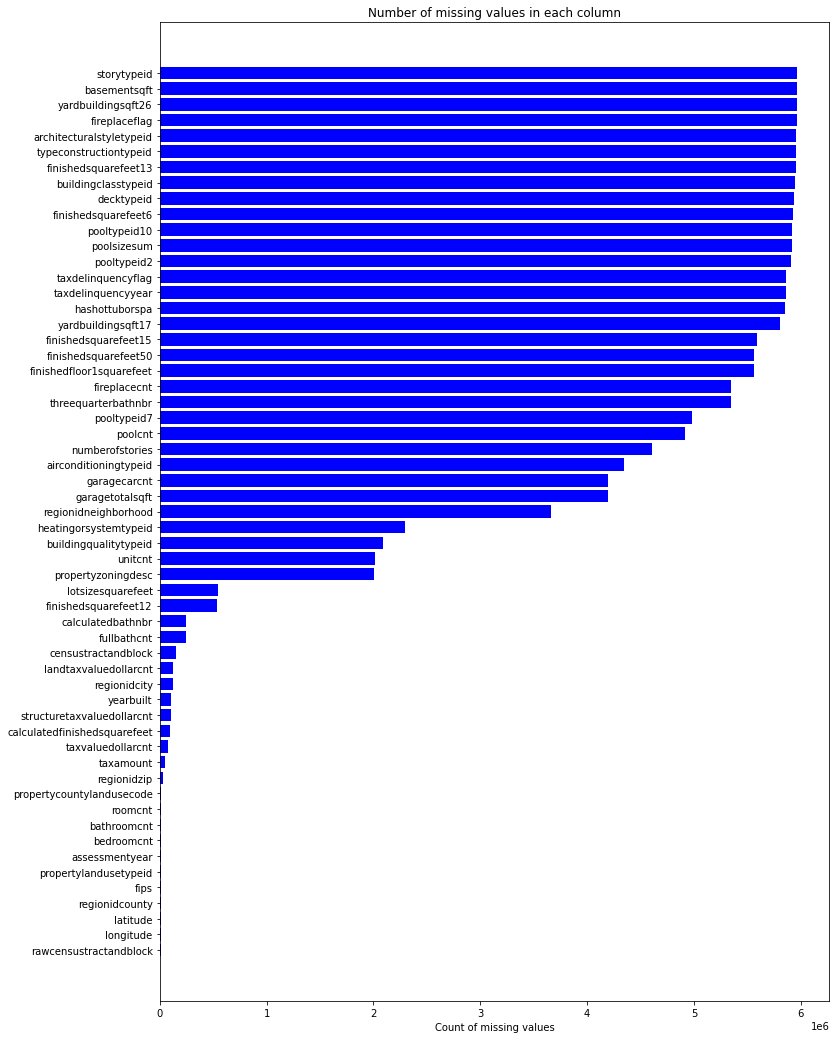

In [14]:
missing_df = prop_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()


We have about 90,811 rows in train but we have about 2,985,217 rows in properties file. So let us merge the two files and then carry out our analysis.

Now we are merging train_df and prop_df so that we can create a complete dataset with features and target

In [15]:
train_df = pd.merge(train_df, prop_df, on='parcelid', how='left')
train_df.head()

,parcelid,logerror,transactiondate,transaction_month,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,11016594,0.0276,2016-01-01,1,1.0,NaN,NaN,2.0,3.0,NaN,...,NaN,NaN,218000.0,545000.0,2016.0,327000.0,6735.88,NaN,NaN,6.037107e+13
2,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
3,14366692,-0.1684,2016-01-01,1,NaN,NaN,NaN,3.5,4.0,NaN,...,NaN,NaN,346458.0,974900.0,2016.0,628442.0,10153.02,NaN,NaN,NaN
4,12098116,-0.0040,2016-01-01,1,1.0,NaN,NaN,3.0,2.0,NaN,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13


Now let us check the dtypes of different types of variable.

In [16]:
pd.options.display.max_rows = 65
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df

,Count,Column Type
0,parcelid,int64
1,logerror,float64
2,transactiondate,datetime64[ns]
3,transaction_month,int64
4,airconditioningtypeid,float64
5,architecturalstyletypeid,float64
6,basementsqft,float64
7,bathroomcnt,float64
8,bedroomcnt,float64
9,buildingclasstypeid,float64


Almost all are float variables with few object (categorical) variables. Let us get the count.



Now let us check the number of Nulls in this new merged dataset

In [17]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df['missing_ratio'] = missing_df['missing_count'] / train_df.shape[0]
missing_df.loc[missing_df['missing_ratio']>0.999]

,column_name,missing_count,missing_ratio
6,basementsqft,335590,0.999446
9,buildingclasstypeid,335713,0.999812
16,finishedsquarefeet13,335626,0.999553
44,storytypeid,335590,0.999446
49,yardbuildingsqft26,335446,0.999017


Five columns have missing values 99.9% of the times.! so we remove it for now.

In [18]:
train_df.drop(['basementsqft','buildingclasstypeid','finishedsquarefeet13','storytypeid','yardbuildingsqft26'],axis=1,inplace=True)

**Univariate Analysis:**

Since there are so many variables, let us first take the 'float' variables alone and then get the correlation with the target variable to see how they are related.

/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


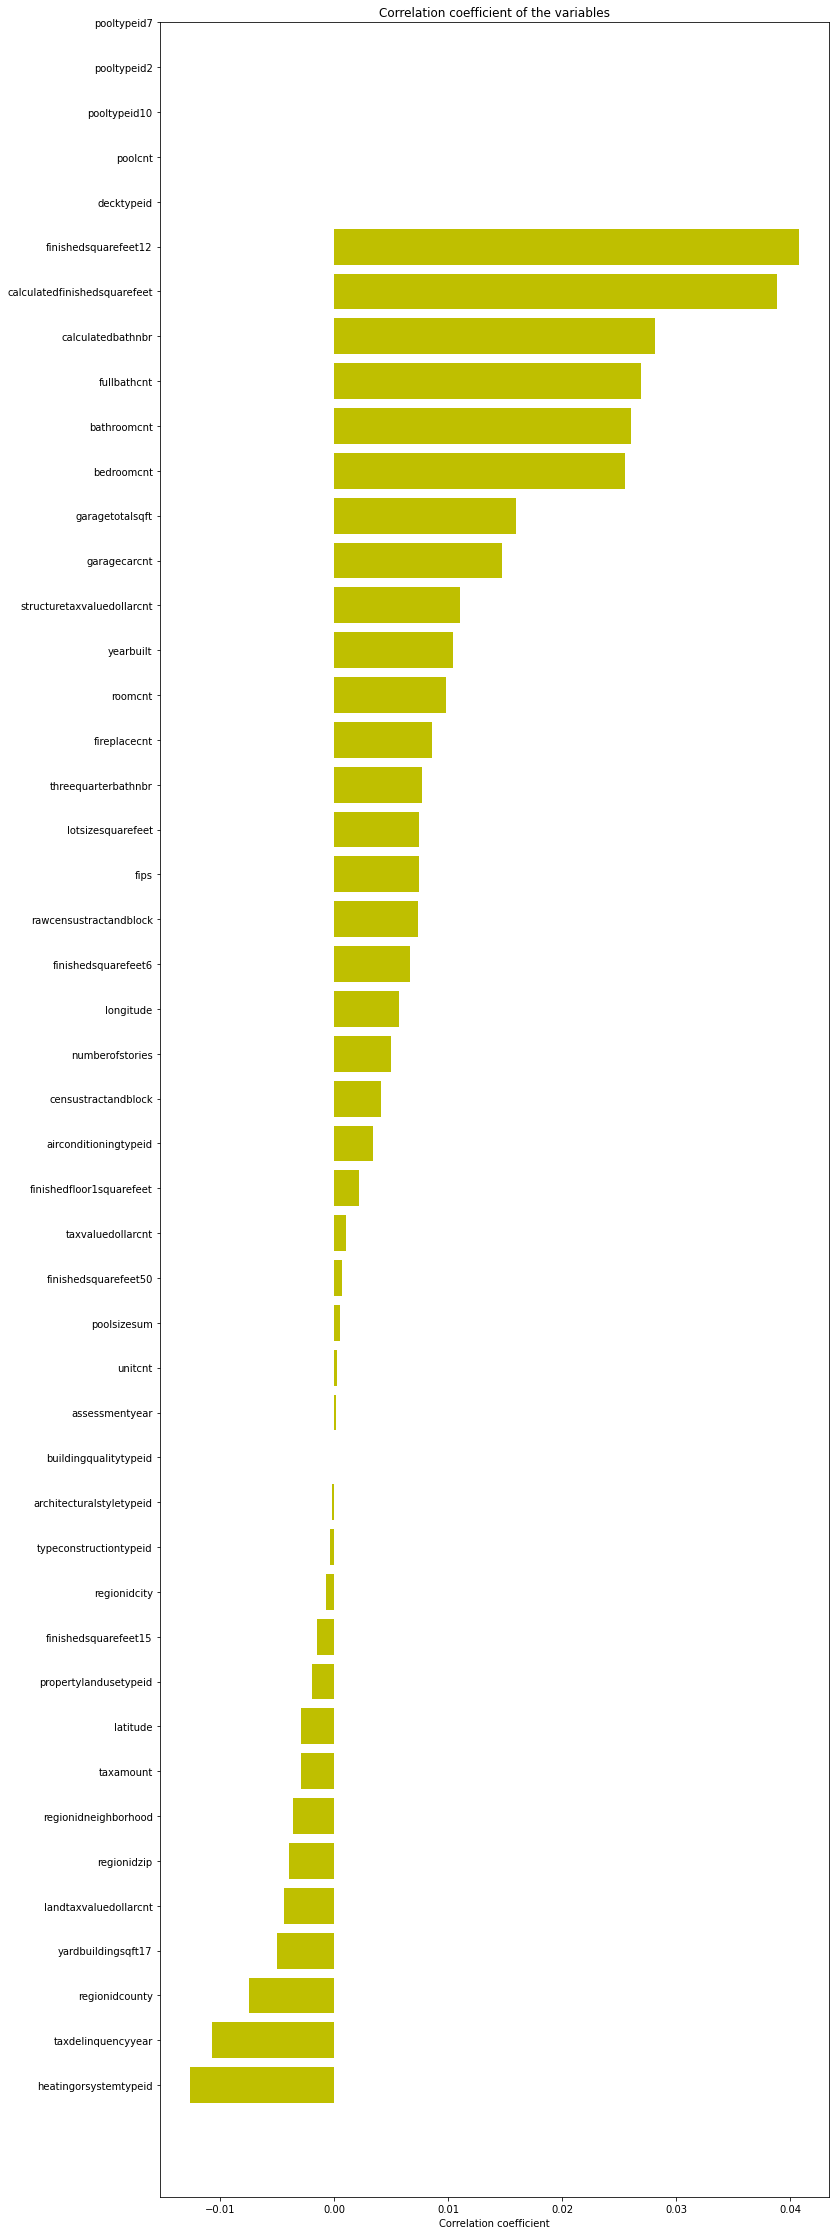

In [19]:
mean_values = train_df.mean(axis=0)
train_df_new = train_df.fillna(mean_values)

# Now let us look at the correlation coefficient of each of these variables #
x_cols = [col for col in train_df_new.columns if col not in ['logerror'] if train_df_new[col].dtype=='float64']

labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, train_df_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')

ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()

The correlation of the target variable with the given set of variables are low overall.

There are few variables at the top of this graph without any correlation values. I guess they have only one unique value and hence no correlation value. Let us confirm the same.

In [20]:

corr_zero_cols = ['assessmentyear', 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid']
for col in corr_zero_cols:
    print(col, len(train_df_new[col].unique()))

assessmentyear 4
pooltypeid2 1
pooltypeid7 1
pooltypeid10 1
poolcnt 1
decktypeid 1


As 5 of the above variables have only one unique value so lets remove them

In [21]:
train_df_new.drop([ 'pooltypeid2', 'pooltypeid7', 'pooltypeid10', 'poolcnt', 'decktypeid'],axis=1,inplace=True)

In [ ]:
train_df_new.isnull().sum()

Below we are creating a function to fill the NA values in the dataset

In [22]:
 def fill_NA(df):

    
    na_ratio = ((df.isnull().sum() / len(df)) * 100).sort_values(ascending=False)
#     print('NA ratio: ')
#     print(na_ratio) 
    
    df['hashottuborspa'] = df['hashottuborspa'].fillna("FALSE")
    df['fireplaceflag'] = df['fireplaceflag'].fillna("FALSE")
    
    for feature in df:
        if df[feature].dtype == 'object':
            df[feature] = df[feature].fillna("None")
        

In [23]:
fill_NA(train_df_new)
fill_NA(prop07_df)
fill_NA(prop06_df)

Now we create a function for encoding the categorical variables using LabelEncoder which is basically encoding the 
categorical variables by providing numbers like 1,2,3,4 etc to the categories

In [24]:
def encode_features(df):
    print('\nEncoding features ...')
    
    for feature in df:
        if df[feature].dtype == 'object':
            print('Encoding ', feature)
            lbl = preprocessing.LabelEncoder()
            lbl.fit(list(df[feature].values))
            df[feature] = lbl.transform(list(df[feature].values))

In [25]:
encode_features(train_df_new)
encode_features(prop06_df)
encode_features(prop07_df)


Encoding features ...
Encoding  hashottuborspa
Encoding  propertycountylandusecode
Encoding  propertyzoningdesc
Encoding  fireplaceflag
Encoding  taxdelinquencyflag

Encoding features ...
Encoding  hashottuborspa
Encoding  propertycountylandusecode
Encoding  propertyzoningdesc
Encoding  fireplaceflag
Encoding  taxdelinquencyflag

Encoding features ...
Encoding  hashottuborspa
Encoding  propertycountylandusecode
Encoding  propertyzoningdesc
Encoding  fireplaceflag
Encoding  taxdelinquencyflag


Now we are creating a function to create additional features so that we can make our data more useful

In [26]:
def add_features(prop_df):
    print('\nAdding features ...')
    
    zip_count = prop_df['regionidzip'].value_counts().to_dict()
    prop_df['N-zip_count'] = prop_df['regionidzip'].map(zip_count)
     
    city_count = prop_df['regionidcity'].value_counts().to_dict()
    prop_df['N-city_count'] = prop_df['regionidcity'].map(city_count)
    
#     prop_df['N-GarPoolAC'] = ((prop_df['garagecarcnt']>0) & (prop_df['pooltypeid10']>0) & (prop_df['airconditioningtypeid']!=5))*1
           
    # Mean square feet of neighborhood properties
    meanarea = prop_df.groupby('regionidneighborhood')['calculatedfinishedsquarefeet'].aggregate('mean').to_dict()
    prop_df['mean_area'] = prop_df['regionidneighborhood'].map(meanarea)
    
    # Median year of construction of neighborhood properties
    medyear = prop_df.groupby('regionidneighborhood')['yearbuilt'].aggregate('median').to_dict()
    prop_df['med_year'] = prop_df['regionidneighborhood'].map(medyear)
    
    # Neighborhood latitude and longitude
    medlat = prop_df.groupby('regionidneighborhood')['latitude'].aggregate('median').to_dict()
    prop_df['med_lat'] = prop_df['regionidneighborhood'].map(medlat)
    
    medlong = prop_df.groupby('regionidneighborhood')['longitude'].aggregate('median').to_dict()
    prop_df['med_long'] = prop_df['regionidneighborhood'].map(medlong)

In [27]:
add_features(train_df_new)
add_features(prop07_df)
add_features(prop06_df)


Adding features ...

Adding features ...

Adding features ...


In [ ]:
prop06_df['year'] = 2016
prop07_df['year'] = 2017

Now are going to look at the distribution of different features with respect to the target variable

In [ ]:
for feature in train_x:
    if train_x[feature].dtype == "float64" or "int64":
        if feature != 'transactiondate':
            fig, ax = plt.subplots()
            ax.scatter(x = train_x[feature], y = train_x['logerror'])
            plt.ylabel('logerror', fontsize=13)
            plt.xlabel(feature, fontsize=13)
            plt.show()  

## **3. Modelling Approach**

We use Xgboost algorithm to find feature importances of different features in the dataset

In [28]:
 xgb_params = {
            'eta': 0.05,
            'max_depth': 8,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'objective': 'reg:linear',
            'silent': 1,
            'seed' : 0
        }
        

[05:58:22] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[05:58:22] WARNING: ../src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




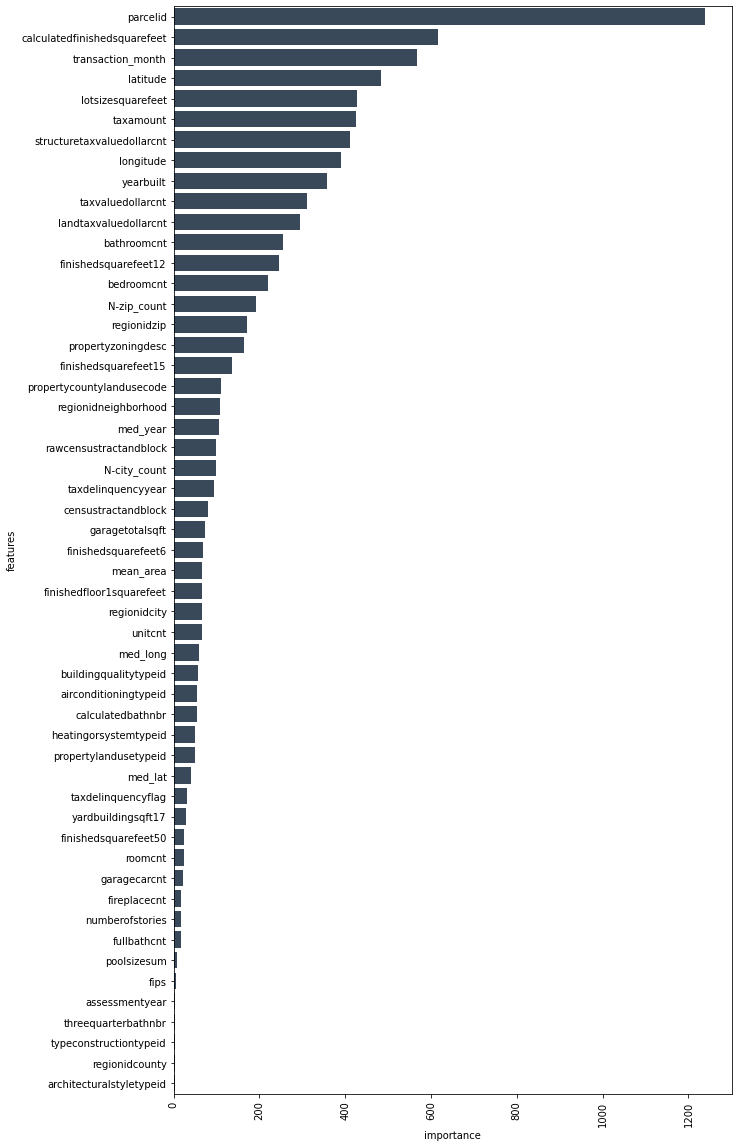

In [29]:
train_y1 = train_df_new.logerror.values
train_x1 = train_df_new.drop(["transactiondate", "logerror"], axis=1)
        
dtrain = xgb.DMatrix(train_x1, train_y1, feature_names=train_x1.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
        
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(10,20)
plt.xticks(rotation=90)
sns.barplot(data=features,x="importance",y="features",ax=ax,orient="h",color="#34495e")      
plt.show()

Dividing the dataset into training and testing

In [30]:
train_y = train_df_new['logerror']
train_df_new.drop(['logerror'], axis=1, inplace=True)

In [31]:
train_df_new.drop(['transactiondate', 'transaction_month'],axis=1,inplace=True)

In [ ]:
# train_y=pd.concat([train_y,valid_y], axis=0)

In [32]:
train_x, valid_x, train_y, valid_y = train_test_split(train_df_new, train_y, test_size=0.25)
print('train x shape: ', train_x.shape)
print('train y shape: ', train_y.shape)
if valid_x is not None:
    print('valid x shape: ', valid_x.shape)
    print('valid y shape: ', valid_y.shape)
else:
    print('valid x shape: None')
    print('valid y shape: None')            
    
    # prepare test data
print('\nPreparing test data')
    
test06_x = prop06_df[train_x.columns]
test07_x = prop07_df[train_x.columns]
        
print('test x shape: ', test06_x.shape)
print('test x shape: ', test07_x.shape)

train x shape:  (251832, 54)
train y shape:  (251832,)
valid x shape:  (83944, 54)
valid y shape:  (83944,)

Preparing test data
test x shape:  (2985217, 54)
test x shape:  (2985217, 54)


In [ ]:
del train06_df
del prop06_df
del train07_df
del prop07_df    
gc.collect()

In the following slides we are optimizing the parameters of xgboost algorithm

In [34]:
 params = {
        'eta': 0.01,
        #'max_depth': 7, 
        #'subsample': 0.6,
        'objective': 'reg:linear',
        'eval_metric': 'mae',
        #'lambda': 5.0,
        #'alpha': 0.65,
        #'colsample_bytree': 0.5,
        #'silent': 1
    }


In [35]:
num_boost_round = 5
d_train = xgb.DMatrix(train_x, label=train_y)
    
eta_list = [0.2, 0.1, 0.05, 0.025, 0.005, 0.0025]
min_mae = float("Inf")
best_eta = eta_list[0]
    
for eta in eta_list:
        # update paramsv
    params['eta'] = eta

        # run cv
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round = num_boost_round,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    
        # print
    mae = cv_results['test-mae-mean'].min()
    rounds = cv_results['test-mae-mean'].argmin()
    print('eta:', eta, '; mae:',mae, '; rounds:', rounds)
    
        # check min mae
    if mae < min_mae:
        min_mae = mae
        best_eta = eta
                    
print('best eta:', best_eta)
print('min mae:', min_mae)
params['eta'] = best_eta

[06:01:23] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:23] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:24] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:25] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
eta: 0.2 ; mae: 0.183143 ; rounds: 4
[06:01:34] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:34] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:35] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:01:36] 

In [36]:
print('\nTuning max_depth and min_child_weight ...')
    
num_boost_round = 5
d_train = xgb.DMatrix(train_x, label=train_y)
    
max_depth_list = list(range(5,10))
min_child_weight_list = list(range(1,5))
min_mae = float("Inf")
best_max_depth = max_depth_list[0]
best_min_child_weight = min_child_weight_list[0]
    
for max_depth, min_child_weight in zip(max_depth_list, min_child_weight_list):
        # update params
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
        
        # run cv
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round = num_boost_round,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
        
        # print
    mae = cv_results['test-mae-mean'].min()
    rounds = cv_results['test-mae-mean'].argmin()
    print('max_depth:', max_depth, '; min_child_weight:', min_child_weight, '; mae:',mae, '; rounds:', rounds)

        # check min mae
    if mae < min_mae:
        min_mae = mae
        best_max_depth = max_depth
        best_min_child_weight = min_child_weight
                    
print('best max_depth:', best_max_depth)
print('best min_child_weight:', best_min_child_weight)
print('min mae:', min_mae)


Tuning max_depth and min_child_weight ...
[06:02:30] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:30] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:31] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:32] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
max_depth: 5 ; min_child_weight: 1 ; mae: 0.1832046 ; rounds: 4
[06:02:39] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:40] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:02:40] WARNING: ../src/objective/regression_obj.cu:171: 

In [37]:
num_boost_round = 4
d_train = xgb.DMatrix(train_x, label=train_y)
    
subsample_list = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
colsample_bytree = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
min_mae = float("Inf")
best_subsample = subsample_list[0]
best_colsample_bytree = colsample_bytree[0]
    
for subsample, colsample_bytree in zip(subsample_list, colsample_bytree):
        # update params
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample_bytree
        
        # run cv
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round = num_boost_round,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
        
        # print
    mae = cv_results['test-mae-mean'].min()
    rounds = cv_results['test-mae-mean'].argmin()
    print('subsample:', subsample, '; colsample_bytree:', colsample_bytree, '; mae:',mae, '; rounds:', rounds)
    
        # check min mae
    if mae < min_mae:
        min_mae = mae
        best_subsample = subsample
        best_colsample_bytree = colsample_bytree
                    
print('best subsample:', best_subsample)
print('best colsample_bytree:', best_colsample_bytree)
print('min mae:', min_mae)
params['subsample'] = best_subsample
params['colsample_bytree'] = best_colsample_bytree

[06:03:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:18] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
subsample: 0.1 ; colsample_bytree: 0.1 ; mae: 0.220265 ; rounds: 3
[06:03:21] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:22] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:03:22] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of

In [38]:
num_boost_round = 4
d_train = xgb.DMatrix(train_x, label=train_y)
    
alpha_list = [0.0, 0.4, 0.8, 1.2, 1.6, 2.0, 2.4, 2.8]
lambda_list = [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0]
min_mae = float("Inf")
best_alpha = alpha_list[0]
best_lambda = lambda_list[0]
    
for alpha, lambdaa in zip(alpha_list, lambda_list):
        # update params
    params['alpha'] = alpha
    params['lambda'] = lambdaa
        
        # run cv
    cv_results = xgb.cv(
        params,
        d_train,
        num_boost_round = num_boost_round,
        nfold=5,
        metrics={'mae'},
        early_stopping_rounds=10
    )
   
        
        # print
    mae = cv_results['test-mae-mean'].min()
    rounds = cv_results['test-mae-mean'].argmin()
    print('alpha:', alpha, '; lambda:', lambdaa, '; mae:',mae, '; rounds:', rounds)
    
        # check min mae
    if mae < min_mae:
        min_mae = mae
        best_alpha = alpha
        best_lambda = lambdaa
                    
print('best alpha: for xgb', best_alpha)
print('best lambda: for xgb', best_lambda)


[06:04:04] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:05] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:06] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:06] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:07] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
alpha: 0.0 ; lambda: 2.0 ; mae: 0.21957819999999995 ; rounds: 3
[06:04:16] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:16] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[06:04:17] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of re

In [39]:
params['subsample'] = best_alpha
params['lambda'] = best_lambda

In [40]:
params['colsample_bytree'] = best_colsample_bytree
params

{'eta': 0.2,
 'objective': 'reg:linear',
 'eval_metric': 'mae',
 'max_depth': 8,
 'min_child_weight': 4,
 'subsample': 0.0,
 'colsample_bytree': 1.0,
 'alpha': 2.8,
 'lambda': 2.0}

In [41]:
best_num_boost_round = 474

Training the Xgboost model

In [42]:
d_train = xgb.DMatrix(train_x, label=train_y)
d_valid = xgb.DMatrix(valid_x, label=valid_y)
evals = [(d_train, 'train'), (d_valid, 'valid')]
xgb_reg = xgb.train(params, d_train,num_boost_round=best_num_boost_round, evals=evals,early_stopping_rounds=100, verbose_eval=10)

[06:05:51] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:0.49600	valid-mae:0.49583
[10]	train-mae:0.49600	valid-mae:0.49583
[20]	train-mae:0.49600	valid-mae:0.49583
[30]	train-mae:0.49600	valid-mae:0.49583
[40]	train-mae:0.49600	valid-mae:0.49583
[50]	train-mae:0.49600	valid-mae:0.49583
[60]	train-mae:0.49600	valid-mae:0.49583
[70]	train-mae:0.49600	valid-mae:0.49583
[80]	train-mae:0.49600	valid-mae:0.49583
[90]	train-mae:0.49600	valid-mae:0.49583
[99]	train-mae:0.49600	valid-mae:0.49583


In [ ]:
params['colsample_bytree']

Making predictions using the xgboost model

In [43]:
test06_x.values.astype(np.float32, copy=False)
test07_x.values.astype(np.float32, copy=False)
d_test06 = xgb.DMatrix(test06_x)
d_test07 = xgb.DMatrix(test07_x)
    
xgb_pred06 = xgb_reg.predict(d_test06)
xgb_pred07 = xgb_reg.predict(d_test07)

Now we are training the CatBoostRegressor algorithm 

In [44]:
ctb_reg = ctb.CatBoostRegressor(iterations=30, learning_rate=0.03,
                                        depth=6, l2_leaf_reg=3,
                                        loss_function='MAE',
                                        eval_metric='MAE')
ctb_reg.fit(train_x, train_y, verbose=True)


0:	learn: 0.0689228	total: 135ms	remaining: 3.92s
1:	learn: 0.0689086	total: 200ms	remaining: 2.79s
2:	learn: 0.0688952	total: 264ms	remaining: 2.38s
3:	learn: 0.0688817	total: 332ms	remaining: 2.16s
4:	learn: 0.0688685	total: 400ms	remaining: 2s
5:	learn: 0.0688554	total: 466ms	remaining: 1.86s
6:	learn: 0.0688441	total: 531ms	remaining: 1.74s
7:	learn: 0.0688332	total: 595ms	remaining: 1.64s
8:	learn: 0.0688235	total: 658ms	remaining: 1.53s
9:	learn: 0.0688133	total: 717ms	remaining: 1.43s
10:	learn: 0.0688029	total: 782ms	remaining: 1.35s
11:	learn: 0.0687928	total: 850ms	remaining: 1.27s
12:	learn: 0.0687842	total: 913ms	remaining: 1.19s
13:	learn: 0.0687735	total: 977ms	remaining: 1.12s
14:	learn: 0.0687650	total: 1.04s	remaining: 1.04s
15:	learn: 0.0687573	total: 1.11s	remaining: 968ms
16:	learn: 0.0687492	total: 1.17s	remaining: 896ms
17:	learn: 0.0687430	total: 1.23s	remaining: 820ms
18:	learn: 0.0687364	total: 1.29s	remaining: 747ms
19:	learn: 0.0687287	total: 1.35s	remaining:

Checking the accuracy of the catboostregressor model using mean absolute error metric

In [45]:
ctb_pred_valid=ctb_reg.predict(valid_x);

In [46]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(valid_y, ctb_pred_valid)


0.06838228426114999

So it is clear that catboostregressor outperforms xgboost algorithm in this case as it has a mean absolute error of 0.675  and xgboost has a mean absolute error of 0.496

making prediction using the CatBoostRegressor model

In [47]:
ctb_pred06 = ctb_reg.predict(test06_x)
ctb_pred07 = ctb_reg.predict(test07_x)